Imports

In [ ]:
from drawing_bot_api.trajectory_optimizer.shape_generator import ShapeGenerator
from drawing_bot_api.trajectory_optimizer.shape_generator import RESTING_POINT
from drawing_bot_api import DrawingBot
from drawing_bot_api.trajectory_optimizer.image_processor import ImageProcessor
from drawing_bot_api.trajectory_optimizer.wiper import Wiper
from drawing_bot_api.trajectory_optimizer.simulator import Simulator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from drawing_bot_api.trajectory_optimizer.training_v4 import Trainer
import signal
from drawing_bot_api.trajectory_optimizer.config_rl import *
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf 
tf.compat.v1.enable_eager_execution()
from ipyparallel import Client
from multiprocessing import TimeoutError
import time
import gc
import os
from IPython.display import clear_output

%matplotlib agg

2025-01-26 13:07:47.071222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Display all elements without truncation
InteractiveShell.ast_node_interactivity = "all"

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [3]:
DEBUG_MODE = False
TEST_MODE = False

In [ ]:
shape_generator = ShapeGenerator()
drawing_bot = DrawingBot()
image_processor = ImageProcessor()
wiper = Wiper()
error_simulator = Simulator(strength=15, pattern_length=20, seed=1)
model = Trainer()

Unit set to "mm".


In [5]:
# handler for timeout
def handler(signum, frame):
    raise TimeoutError("Operation timed out")

signal.signal(signal.SIGALRM, handler)


<Handlers.SIG_DFL: 0>

In [6]:
def plot_graph(data, labels, scale='linear'):
    plt.yscale(scale)
    for _i in range(len(data)):
        plt.plot(data[_i], label=labels[_i])
    plt.legend(bbox_to_anchor=(1, 1.15), ncol=3)  
    plt.show() 

In [7]:
TEST_SHAPE = None
if TEST_MODE:
    TEST_SHAPE = shape_generator(seed=1)
    for shape in TEST_SHAPE:
        drawing_bot.add_shape(shape)
    TEST_TRAJECTORY = np.array(drawing_bot._get_all_points())
    TEST_TEMPLATE = np.array(drawing_bot.plot(training_mode=True, points=TEST_TRAJECTORY))
    drawing_bot.shapes.clear()

def get_template():
    if TEST_MODE:
        return TEST_TRAJECTORY, TEST_TEMPLATE
    
    for shape in shape_generator():
        drawing_bot.add_shape(shape)
    # get template for drawing
    trajectory = np.array(drawing_bot._get_all_points())
    template = np.array(drawing_bot.plot(training_mode=True, points=trajectory))
    drawing_bot.shapes.clear()
    
    return trajectory, template

In [8]:

def get_adjusted_trajectory(trajectory):
    adjusted_trajectory = np.array(model.adjust_trajectory(trajectory))
    adjusted_template = np.array(drawing_bot.plot(training_mode=True, points=adjusted_trajectory))
    return adjusted_trajectory, adjusted_template


In [9]:
def simulate_drawing(adjusted_trajectory):    
    simulated_trajctory = error_simulator(adjusted_trajectory)
    drawing = np.array(drawing_bot.plot(training_mode=True, points=simulated_trajctory))
    return simulated_trajctory, drawing


In [11]:
def get_images_of_individual_points(trajectory, resolution):
    _images = [] 
    _points = np.array(trajectory)

    for _index in range(0, int(len(_points)), resolution):
        _images.append(drawing_bot.plot(training_mode=True, points=_points[_index:_index+resolution]))
    plt.close('all')
    return _images

In [12]:
def get_rewards(template, drawing, trajectory):
        if GRANULAR_REWARD:
            resolution = GRANULAR_REWARD_RESOLUTION
            _images_of_template_points = get_images_of_individual_points(trajectory, resolution)
            rewards = np.array(image_processor.calc_rewards_for_individual_points(_images_of_template_points, drawing))
            rewards = np.repeat(rewards, resolution, axis=0)
            rewards = np.nan_to_num(rewards, nan=1)
            
            return rewards
        
        else:
            reward = image_processor(template, drawing=drawing)
            if reward is None:
                return None
            return reward

In [13]:
def fit_model(reward):
    model.train(reward)

In [14]:
def save_visualization(trajectory, rewards, cycle_index, name):
    reward_assigned_drawing = drawing_bot.plot(training_mode=True, points=trajectory, color_assignment=rewards)
    image_processor.save_image(reward_assigned_drawing, name, f'{name}_visualization', cycle_index)
    del reward_assigned_drawing

def save_combined_visualization(metric1, metric2, metric3, cycle_index, name, file_name=None):
    if file_name is None: file_name = name 
    metric1_drawing = drawing_bot.plot(training_mode=True, points=metric1[1], color_assignment=metric1[0])
    metric2_drawing = drawing_bot.plot(training_mode=True, points=metric2[1], color_assignment=metric2[0])
    metric3_drawing = drawing_bot.plot(training_mode=True, points=metric3[1], color_assignment=metric3[0])
    image_processor.save_images_combined(metric1_drawing, metric2_drawing, metric3_drawing, name, file_name, cycle_index)
    del metric1_drawing, metric2_drawing

In [15]:
def graph_all(model):
    %matplotlib inline

    reward_history = np.mean(model.reward_history, axis=1)

    loss_history = np.array(model.loss_history)

    critic_output = model.output_history[:, 4:]
    critic_mean = np.mean(critic_output, axis=1)
    critic_min = np.min(critic_output, axis=1)
    critic_max = np.max(critic_output, axis=1)
    
    actor_means = model.output_history[:, :2]
    means_mean = np.mean(actor_means, axis=1)
    means_min = np.min(actor_means, axis=1)
    means_max = np.max(actor_means, axis=1)

    actor_sigmas = model.output_history[:, 2:4]
    sigma_mean = np.mean(actor_sigmas, axis=1)
    sigma_min = np.min(actor_sigmas, axis=1)
    sigma_max = np.max(actor_sigmas, axis=1)

    #plot rewards and losses
    reward_history_smooth = gaussian_filter1d(reward_history, sigma=10)
    loss_history_smooth = gaussian_filter1d(loss_history, sigma=10)
    #critic_mean = gaussian_filter1d(model.critic_mean_log, sigma=2)
    #critic_var = gaussian_filter1d(model.critic_var_log, sigma=2)
    #critic_min = gaussian_filter1d(model.critic_min_log, sigma=2)
    #critic_max = gaussian_filter1d(model.critic_max_log, sigma=2)

    #print(f'\nInitial weights:\n{inital_weights}')
    #print(f'\n\nWeights in the end:\n{end_weights}\n')

    plot_graph([loss_history, loss_history_smooth], ['loss', 'loss smooth'], scale='symlog')
    plot_graph([reward_history, reward_history_smooth], ['reward', 'reward smooth'])
    plot_graph([sigma_mean, sigma_min, sigma_max], ['sigma mean', 'sigma min', 'sigma max'])
    plot_graph([means_mean, means_min, means_max], ['means mean', 'means min', 'means max'])
    plot_graph([model.action_mean_log, model.action_max_log, model.action_min_log], ['action average', 'action max', 'action min'])
    plot_graph([critic_mean, critic_min, critic_max], ['Critic mean', 'Critic min', 'Critic max'])

    %matplotlib agg

In [16]:
def training_cycle(cycle_index, num_of_cycles):
    signal.alarm(30)

    try:
        trajectory, template = get_template()

        adjusted_trajectory, adjusted_template = get_adjusted_trajectory(trajectory)
        simulated_trajectory, drawing = simulate_drawing(adjusted_trajectory)
        
        reward, _ = get_rewards(template, drawing, trajectory)
        advantages, critic_output = fit_model(reward)

        if cycle_index % SAVE_IMAGE_FREQ == 0:
            _file_name = None #f'rwd_{np.mean(rewards)}__loss_{model.action_mean_log[-1]}'
            _rewards = (reward * 2) - 1

            _sigma_values = model._normalize_to_range_pos(_sigma_values)
            _mean_values = model._normalize_to_range_incl_neg(_mean_values)

            save_combined_visualization([advantages, adjusted_trajectory], [reward, simulated_trajectory], [None, trajectory], cycle_index, 'reward_advantage', file_name=_file_name)
            image_processor.save_image(drawing, 'original', 'drawing', cycle_index)

        if np.mean(reward) > np.mean(model.reward_history):
            save_combined_visualization([advantages, adjusted_trajectory], [reward, simulated_trajectory], [None, trajectory], cycle_index, 'high_reward', file_name=f'reward_advantage_{reward}')
    
        del adjusted_trajectory, adjusted_template, simulated_trajectory, drawing, trajectory, template

        print(f'{bcolors.HEADER}Cylce: {cycle_index}\t{bcolors.ENDC}{bcolors.OKCYAN}Reward: {reward_log[-1]}{bcolors.ENDC}')
    
    except TimeoutError as e:
        if DEBUG_MODE:
            raise
        else:
            print(f"Timeout occurred: {e}")

    finally:
        signal.alarm(0)  # Cancel the alarm
        if 0:
            gc.collect()
    


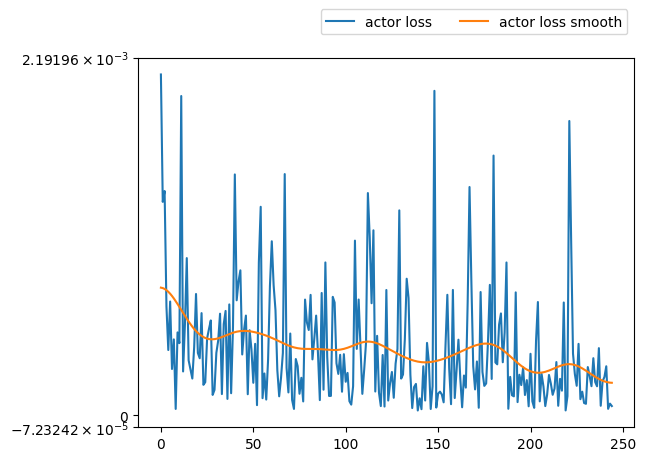

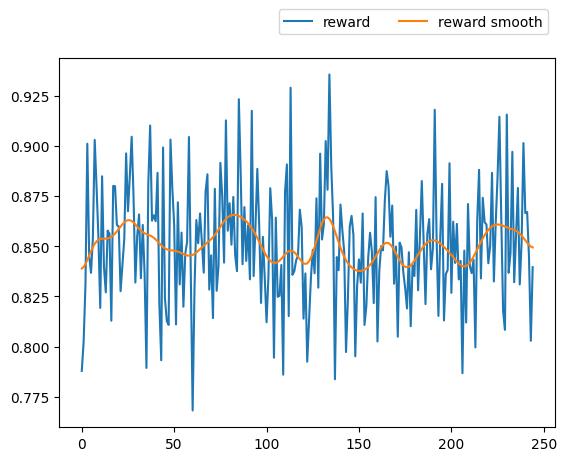

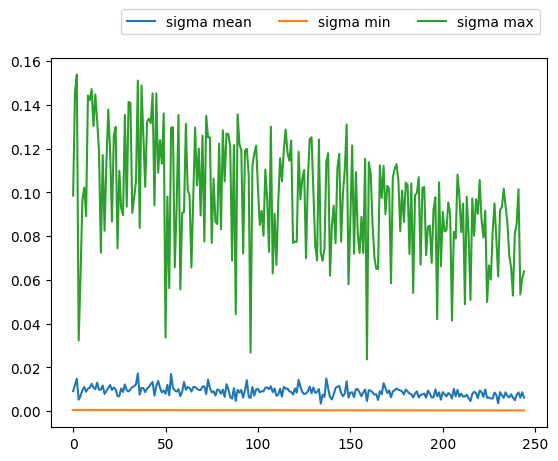

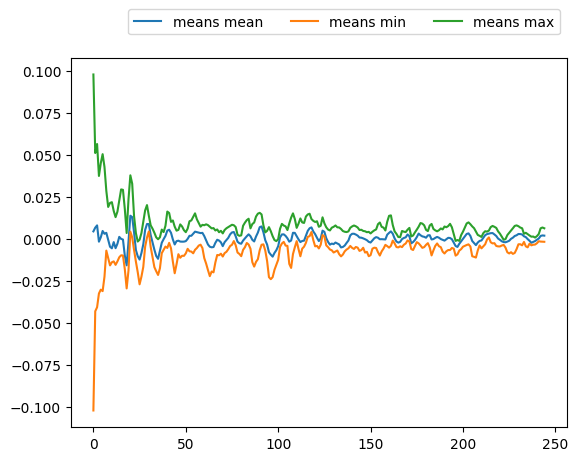

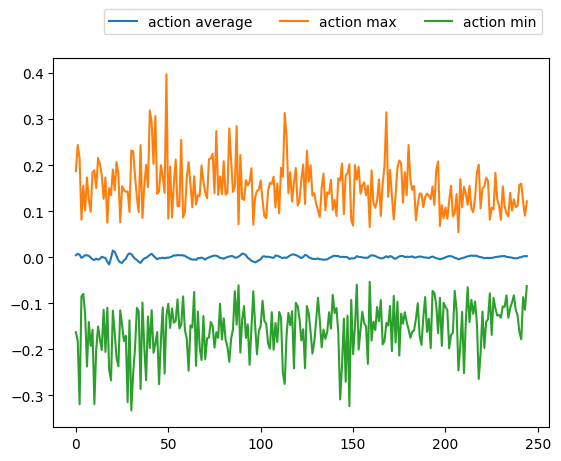

Critic | mean: 0.6662885546684265	var: 7.282981823664159e-05	min: 0.6173599362373352	max: 0.6868234872817993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0010
(539, 2)
(539,)
[[-0.00048843  0.00366764]
 [-0.00049864  0.00366063]
 [ 0.00066321 -0.00476199]
 [ 0.00067652 -0.00475292]
 [ 0.00069052 -0.00474395]
 [-0.00054067  0.00363248]
 [-0.00055041  0.00362441]
 [-0.00056015  0.00361634]
 [ 0.0004609  -0.0111412 ]
 [-0.01615996 -0.01506292]
 [ 0.01280794  0.01190339]
 [-0.0005991   0.00358404]
 [-0.00060884  0.00357597]
 [-0.00061858  0.00356789]
 [-0.00086036  0.00341363]
 [-0.00087098  0.0034073 ]
 [-0.02310793 -0.03608637]
 [-0.01630507 -0.00950985]
 [-0.02040312  0.00478521]
 [-0.00091346  0.00338197]
 [-0.00092408  0.00337564]
 [-0.0009347   0.00336931]
 [-0.00095593  0.00335665]
 [-0.00096656  0.00335031]
 [ 0.002273    0.00365636]
 [ 0.00675813  0.00466906]
 [ 0.00276777  0.00846128]
 [-0.00100903  0.00332499]
 [-0.00101931  0.00331845]
 [-0.00102839  0

In [ ]:
for i in range(NUM_OF_CYCLES):
    if i % 10 == 9:
        clear_output(wait=True)
        graph_all(model)

    #print(f'Cylce: {i}')
    if training_cycle(i, NUM_OF_CYCLES):
        break
    plt.close('all')

%matplotlib inline

os.system('say "Program has finished"') # sound effect